# Klasyfikacja ręcznie pisanych cyfr za pomocą CNN oraz Gradient Boosting

## Biblioteki oraz zestaw danych

In [10]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import tee
%matplotlib inline
import matplotlib.pyplot as plt                         # Wykresy
import numpy as np                                      # Macierze i typy
from sklearn import datasets                            # Wczytywanie zestawu danych
from sklearn.ensemble import GradientBoostingClassifier # Algorytm gradient boosting
from sklearn.metrics import classification_report       # Obliczanie błędu modelu
from sklearn.utils import shuffle                       # Randomizowanie zestawu danych

# biblioteki do CNN 
import tensorflow as tf
import keras                                            
from keras.utils import np_utils

# wczytanie zestawu danych MNIST
from keras.datasets import mnist

# rodzaj modelu
from keras.models import Sequential

# warstwy sieci neuronowej
from keras.layers import Conv2D, MaxPooling2D        
from keras.layers import Flatten, Dense, Dropout

In [2]:
# TODO: wczytać MNIST, a nie ten uproszczony zbiór
digits = datasets.load_digits()

In [3]:
def pairwise(iterable):
    """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

# Wczytanie danych MNIST

In [11]:
(train_img, train_labels), (test_img, test_labels) = mnist.load_data()

## Analiza danych MNIST

In [12]:
print("Zbiór danych MNIST składa się z ", train_img.shape[0], " instancji.")

Zbiór danych MNIST składa się z  60000  instancji.


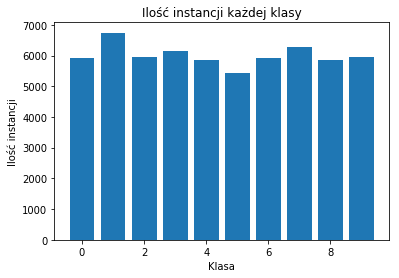

In [13]:
(classes, elements) = np.unique(train_labels, return_counts=True)
plt.title("Ilość instancji każdej klasy")
plt.xlabel("Klasa")
plt.ylabel("Ilość instancji")
_ = plt.bar(classes, elements)

In [14]:
print("Każda instancja posiada", train_img.shape[1] * train_img.shape[1], "cech.")

Każda instancja posiada 784 cech.


Zestaw danych składa się z obrazów 28 x 28 px, przedstawiających ręcznie pisane cyfry. Poniżej zaprezentowana jest pierwsza instancja zestawu.

Text(0.5, 1.0, '5')

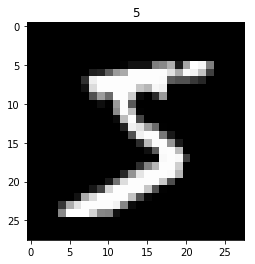

In [15]:
plt.imshow(train_img[0], cmap='gray')
plt.title(train_labels[0])

## Przygotowanie danych do uczenia

In [16]:
train_img = train_img.reshape(60000, 28, 28, 1)
test_img = test_img.reshape(10000, 28, 28, 1) 

In [17]:
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')

In [18]:
train_img /= 255
test_img /= 255

In [19]:
train_labels = np_utils.to_categorical(train_labels, 10) 
test_labels = np_utils.to_categorical(test_labels, 10)

print(train_img.shape)
print(test_labels.shape)
print(train_labels[0])

(60000, 28, 28, 1)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Konwolucyjna sieć neuronowa

## Budowa modelu

In [25]:
def build_CNN():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1))) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Utworzenie sieci

In [27]:
model = build_CNN()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                200768    
__________

## Uczenie sieci

In [29]:
result = model.fit(train_img, train_labels,
                   epochs = 15,
                   batch_size = 128,
                   verbose = 1,
                   validation_data = (test_img, test_labels))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 58s 970us/step - loss: 0.1942 - acc: 0.9394 - val_loss: 0.0716 - val_acc: 0.9763
Epoch 2/15
60000/60000 [==============================] - 56s 934us/step - loss: 0.0494 - acc: 0.9851 - val_loss: 0.0351 - val_acc: 0.9892
Epoch 3/15
60000/60000 [==============================] - 56s 935us/step - loss: 0.0338 - acc: 0.9895 - val_loss: 0.0363 - val_acc: 0.9875
Epoch 4/15
60000/60000 [==============================] - 56s 937us/step - loss: 0.0258 - acc: 0.9918 - val_loss: 0.0321 - val_acc: 0.9898
Epoch 5/15
60000/60000 [==============================] - 57s 948us/step - loss: 0.0220 - acc: 0.9932 - val_loss: 0.0262 - val_acc: 0.9912
Epoch 6/15
60000/60000 [==============================] - 56s 938us/step - loss: 0.0156 - acc: 0.9952 - val_loss: 0.0288 - val_acc: 0.9901
Epoch 7/15
60000/60000 [==============================] - 56s 941us/

## Prezentacja graficzna wyników

In [36]:
history = result.history
train_acc = history['acc']
train_loss = history['loss']
val_acc = history['val_acc']
val_loss = history['val_loss']

epochs = range(1, len(train_acc)+1)

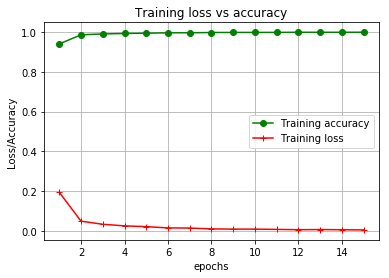

In [40]:
plt.plot(epochs, train_acc, 'go-', label='Training accuracy')
plt.plot(epochs, train_loss, 'r+-', label='Training loss')
plt.legend()
plt.title('Training loss vs accuracy')
plt.xlabel('epochs')
plt.ylabel('Loss/Accuracy')
plt.grid()

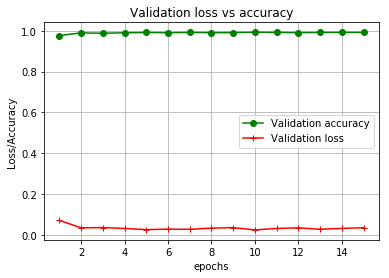

In [41]:
plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
plt.plot(epochs, val_loss, 'r+-', label='Validation loss')
plt.legend()
plt.title('Validation loss vs accuracy')
plt.xlabel('epochs')
plt.ylabel('Loss/Accuracy')
plt.grid()

## Ewaluacja modelu

In [44]:
score = model.evaluate(test_img, test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 2s 193us/step
Test loss: 0.03542381918878805
Test accuracy: 0.9913


# Od tego miejsca w dół nie ruszałem ;P

## Analiza danych

In [19]:
print("Zbiór danych składa się z", digits.data.shape[0], "instancji.")

Zbiór danych składa się z 1797 instancji.


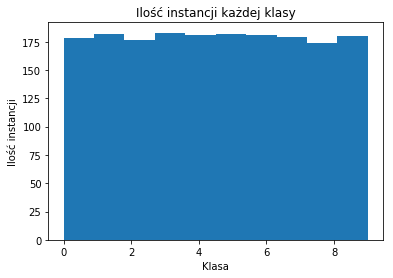

In [18]:
plt.title("Ilość instancji każdej klasy")
plt.xlabel("Klasa")
plt.ylabel("Ilość instancji")
_ = plt.hist(digits.target, bins=len(digits.target_names))

In [6]:
print("Każda instancja posiada", digits.data.shape[1], "cechy.")

Każda instancja posiada 64 cechy.


Zestaw danych składa się z obrazów 8 x 8 px, przedstawiających ręcznie pisane cyfry.
Poniżej zaprezentowana jest pierwsza instancja zestawu.

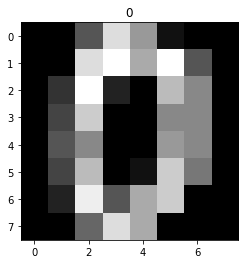

In [7]:
plt.title(digits.target[0])
_ = plt.imshow(np.reshape(digits.data[0], (8, 8)), cmap='gray')

Wg, żródła[^1], większość ludzi preferuje oglądać obrazy rozmazane zamiast obrazów w małej rozdzielczości.
W związku z tym, od tego momentu przy wyświetlaniu obrazów posłużymy się interpolacją.

[^1]: https://matplotlib.org/users/image_tutorial.html 

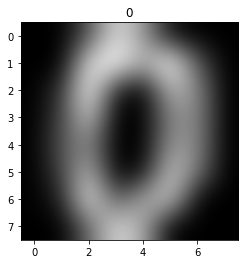

In [8]:
plt.title(digits.target[0])
_ = plt.imshow(np.reshape(digits.data[0], (8, 8)), cmap='gray', interpolation='bicubic')

Aby zapoznać czytelnika z zestawem danych, poniżej prezentujemy jeszcze kilka instancji różnych klas.

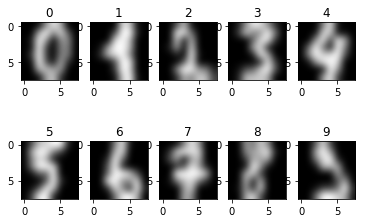

In [9]:
for idx in range(0, 10):
    instance_no = 10 + idx
    plt.subplot(2, 5, 1 + idx)
    plt.title(digits.target[instance_no])
    _ = plt.imshow(np.reshape(digits.data[instance_no], (8, 8)), cmap='gray', interpolation='bicubic')

## Przygotowanie danych do procesu uczenia

Przygotowanie danych do procesu uczenia rozpoczęliśmy od randomizacji zestawu.

In [10]:
x, y = shuffle(digits.data, digits.target, random_state=13)

Aby podczas procesu walidacji modelu dokonać k-krotnej walidacji krzyżowej, podzieliliśmy zestaw na k podzbiorów.

In [11]:
k = 10

split_points = np.linspace(0, digits.data.shape[0], k + 1, dtype=int)

x_subsets = [x[start:end] for start, end in pairwise(split_points)]
y_subsets = [y[start:end] for start, end in pairwise(split_points)]

# Drzewo decyzyjne

## Budowanie modelu

In [12]:
classifiers = [None] * k

with ProcessPoolExecutor() as executor:
    def fit(idx):
        classifier = GradientBoostingClassifier()
        classifier.fit(
            np.concatenate(x_subsets[:idx] + x_subsets[idx+1:]),
            np.concatenate(y_subsets[:idx] + y_subsets[idx+1:]),
        )
        return classifier
    
    future_to_classifier = {executor.submit(fit, idx): idx for idx in range(k)}
    
    for future in as_completed(future_to_classifier):
        idx = future_to_classifier[future]
        classifiers[idx] = future.result()
        

### Ewaluacja modelu

In [13]:
y_true = y
y_pred = np.concatenate([classifier.predict(x_test) for classifier, x_test in zip(classifiers, x_subsets)])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       178
           1       0.95      0.98      0.96       182
           2       0.99      0.97      0.98       177
           3       0.99      0.94      0.96       183
           4       0.99      0.98      0.99       181
           5       0.97      0.95      0.96       182
           6       0.99      0.97      0.98       181
           7       0.97      0.98      0.97       179
           8       0.90      0.98      0.94       174
           9       0.93      0.95      0.94       180

   micro avg       0.97      0.97      0.97      1797
   macro avg       0.97      0.97      0.97      1797
weighted avg       0.97      0.97      0.97      1797



## Użycie modelu w praktyce

In [15]:
classifier = GradientBoostingClassifier()
_ = classifier.fit(x, y)

## Podsumowanie